<a href="https://colab.research.google.com/github/Cyrus-White/HW-Project-Files-/blob/main/Project_ML_Official.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.1882 - val_loss: 0.0280
Epoch 2/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0427 - val_loss: 0.0236
Epoch 3/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0360 - val_loss: 0.0171
Epoch 4/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0361 - val_loss: 0.0169
Epoch 5/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0360 - val_loss: 0.0159
Epoch 6/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0325 - val_loss: 0.0243
Epoch 7/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0362 - val_loss: 0.0249
Epoch 8/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0285 - val_loss: 0.0146
Epoch 9/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0313 - val_loss: 0.0144
Epoch 10/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0317 - val_loss: 0.0153
Epoch 11/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0288 - val_loss: 0.0224
Epoch 12/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0

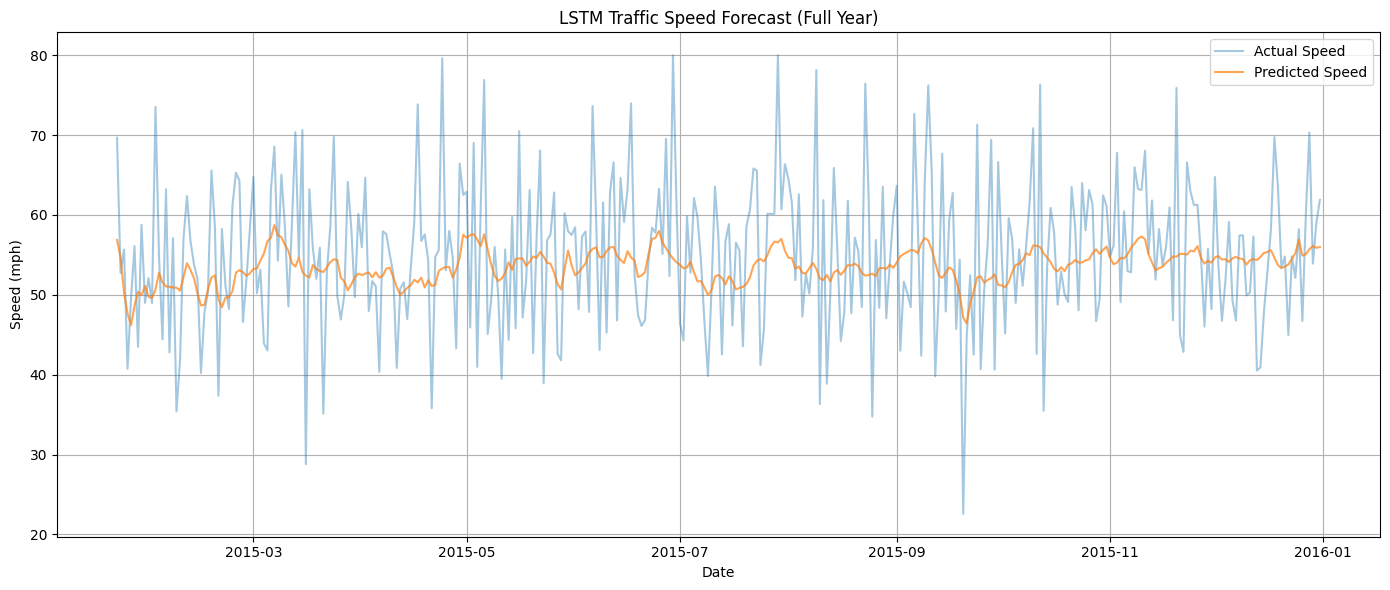

🛑 Top 10 Most Congested Days (Lowest Predicted Speeds):
          Date  Predicted_Speed  Actual_Speed
4   2015-01-25        46.214062     49.556173
243 2015-09-21        46.423073     44.756124
242 2015-09-20        47.138512     22.587327
3   2015-01-24        47.673756     40.752518
30  2015-02-20        48.454372     58.240840
5   2015-01-26        48.629169     56.109226
24  2015-02-14        48.690475     40.214780
25  2015-02-15        48.736179     47.801558
244 2015-09-22        48.942009     52.474318
29  2015-02-19        49.466347     37.369598

📊 Final Model Evaluation (±10 mph Window):
MAE: 7.23 mph
RMSE: 9.02 mph
R² Score: 0.0630
Accuracy (±10 mph): 74.78%


In [23]:
# STEP 0: Install dependencies
!pip install tensorflow pandas matplotlib seaborn scikit-learn openpyxl --quiet

# STEP 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# STEP 2: Load and preprocess
file_path = "/content/Traffic_Weather_Holiday_2015.xlsx"
df = pd.read_excel(file_path, engine='openpyxl')
df['Date'] = pd.to_datetime(df['Date'])
df['dayofweek'] = df['Date'].dt.dayofweek
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year
df['dayofyear'] = df['Date'].dt.dayofyear
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
df['temp_precip_interaction'] = df['Avg_Temperature_F'] * df['Precipitation_in']
df['temp_squared'] = df['Avg_Temperature_F']**2
df['precip_squared'] = df['Precipitation_in']**2
df['lag_1'] = df['Avg_Traffic_Speed_mph'].shift(1)
df['rolling_mean_7'] = df['Avg_Traffic_Speed_mph'].rolling(7).mean()
df.dropna(inplace=True)

# STEP 3: Feature selection
features = [
    'Avg_Temperature_F', 'Precipitation_in', 'Is_Holiday', 'dayofweek', 'month',
    'year', 'dayofyear', 'is_weekend',
    'temp_precip_interaction', 'temp_squared', 'precip_squared',
    'lag_1', 'rolling_mean_7'
]
target = 'Avg_Traffic_Speed_mph'

X = df[features]
y = df[target].values.reshape(-1, 1)
dates = df['Date'].values

# Scale
X_scaled = StandardScaler().fit_transform(X)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y)

# STEP 4: Create sequences
def create_sequences(X_data, y_data, date_data, seq_len):
    X_seq, y_seq, d_seq = [], [], []
    for i in range(len(X_data) - seq_len):
        X_seq.append(X_data[i:i + seq_len])
        y_seq.append(y_data[i + seq_len])
        d_seq.append(date_data[i + seq_len])
    return np.array(X_seq), np.array(y_seq), np.array(d_seq)

sequence_length = 14
X_seq, y_seq, d_seq = create_sequences(X_scaled, y_scaled, dates, sequence_length)

X_train, y_train = X_seq, y_seq
dates_final = d_seq

# STEP 5: Build and train model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=200,
    batch_size=8,
    callbacks=[early_stop],
    verbose=1
)

# STEP 6: Predict and evaluate
y_pred_scaled = model.predict(X_train).flatten()
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = y[sequence_length:].flatten()
dates_plot = pd.to_datetime(dates_final)

tolerance = 10.0
within_margin = np.abs(y_pred - y_true) <= tolerance
accuracy_10 = np.mean(within_margin)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

# STEP 7: Forecast plot
plt.figure(figsize=(14, 6))
plt.plot(dates_plot, y_true, label='Actual Speed', alpha=0.4)
plt.plot(dates_plot, y_pred, label='Predicted Speed', alpha=0.7)
plt.title('LSTM Traffic Speed Forecast (Full Year)')
plt.xlabel('Date')
plt.ylabel('Speed (mph)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# STEP 8: Output top congested days
results_df = pd.DataFrame({
    'Date': dates_plot,
    'Predicted_Speed': y_pred,
    'Actual_Speed': y_true
})
most_congested = results_df.sort_values(by='Predicted_Speed').head(10)
print("🛑 Top 10 Most Congested Days (Lowest Predicted Speeds):")
print(most_congested[['Date', 'Predicted_Speed', 'Actual_Speed']])

# STEP 9: Final metrics
print("\n📊 Final Model Evaluation (±10 mph Window):")
print(f"MAE: {mae:.2f} mph")
print(f"RMSE: {rmse:.2f} mph")
print(f"R² Score: {r2:.4f}")
print(f"Accuracy (±10 mph): {accuracy_10 * 100:.2f}%")
